# New Idea!

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [19]:
# Image Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load Omniglot Dataset
train_dataset = datasets.Omniglot(
    root='./data',
    background=True,
    transform=transform,
    download=True
)

test_dataset = datasets.Omniglot(
    root='./data',
    background=False,
    transform=transform,
    download=True
)


100%|████████████████████████████████████████████████████████████████████| 9464212/9464212 [00:23<00:00, 406141.74it/s]


Extracting ./data\omniglot-py\images_background.zip to ./data\omniglot-py


100%|████████████████████████████████████████████████████████████████████| 6462886/6462886 [00:28<00:00, 229593.58it/s]


Extracting ./data\omniglot-py\images_evaluation.zip to ./data\omniglot-py


In [38]:
def create_episode(dataset, n_way, k_shot, k_query):
    # Get the list of labels
    if hasattr(dataset, 'targets'):
        labels = dataset.targets
    else:
        labels = [label for _, label in dataset._flat_character_images]
    
    # Get unique classes
    classes = list(set(labels))
    
    # Build a mapping from class label to indices of images
    class_to_indices = {cls: [] for cls in classes}
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [cls for cls in classes if len(class_to_indices[cls]) >= k_shot + k_query]
    
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot]
        query_indices = selected_indices[k_shot:]
        
        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])
        
        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])
    
    support_images = torch.stack(support_images)
    query_images = torch.stack(query_images)
    support_labels = torch.tensor(support_labels)
    query_labels = torch.tensor(query_labels)
    
    return support_images, support_labels, query_images, query_labels


In [39]:
# Simplified Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        batch_size = x.size(0)
        x = x.view(batch_size, 32 * 8 * 8, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)


In [40]:
# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings


In [41]:
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances


In [42]:
def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances


In [43]:
def train_prototypical_network(model, dataset, optimizer, num_episodes=1000, n_way=5, k_shot=5, k_query=15):
    model.train()
    for episode in range(num_episodes):
        support_images, support_labels, query_images, query_labels = create_episode(
            dataset, n_way, k_shot, k_query)
        
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        optimizer.zero_grad()

        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)

        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")


In [44]:
def test_prototypical_network(model, train_dataset, test_dataset, n_way=5, k_shot=5, k_query=15, threshold=1.0):
    model.eval()
    with torch.no_grad():
        # Support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, n_way, k_shot, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Query set from test dataset (unseen classes)
        _, _, query_images, query_labels = create_episode(
            test_dataset, n_way, k_shot=0, k_query=k_query)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        query_embeddings = model(query_images)

        # Open-set recognition
        predicted_labels, min_distances = open_set_recognition(query_embeddings, prototypes, threshold)

        # Map unknown classes to -1
        true_labels = torch.full_like(query_labels, -1)
        accuracy = (predicted_labels == true_labels).float().mean().item()
        print(f"Test Accuracy (Open-Set Recognition): {accuracy * 100:.2f}%")


In [45]:
# Initialize model and optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
def count_classes_with_enough_samples(dataset, min_samples):
    # Get the list of labels
    if hasattr(dataset, 'targets'):
        labels = dataset.targets
    else:
        labels = [label for _, label in dataset._flat_character_images]
    
    # Build a mapping from class label to indices of images
    from collections import Counter
    label_counts = Counter(labels)
    classes_with_enough_samples = [cls for cls, count in label_counts.items() if count >= min_samples]
    print(f"Total classes: {len(set(labels))}")
    print(f"Classes with at least {min_samples} samples: {len(classes_with_enough_samples)}")
    return classes_with_enough_samples

# Check the number of classes with at least k_shot + k_query samples
classes_available = count_classes_with_enough_samples(train_dataset, k_shot + k_query)


Total classes: 964
Classes with at least 15 samples: 964


In [47]:
# Training parameters
num_episodes = 1000
n_way = 5       # Number of classes per episode
k_shot = 5      # Number of support samples per class
k_query = 5     # Number of query samples per class

train_prototypical_network(model, train_dataset, optimizer, num_episodes, n_way, k_shot, k_query)


RuntimeError: shape '[50, 2048, 8]' is invalid for input of size 460800

In [ ]:
# Testing parameters
threshold = 1.0  # Threshold for open-set recognition

test_prototypical_network(model, train_dataset, test_dataset, n_way, k_shot, k_query, threshold)


In [ ]:
class GuidedBackpropReLUModel:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                if isinstance(module, nn.ReLU):
                    module_top._modules[idx] = GuidedReLU()
                elif len(module._modules) > 0:
                    recursive_relu_apply(module)

        recursive_relu_apply(self.model)

    def generate_gradients(self, input_image, target_class):
        input_image = input_image.to(device)
        input_image.requires_grad = True
        output = self.model(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros(output.shape, dtype=torch.float).to(device)
        grad_target_map[0][target_class] = 1
        output.backward(grad_target_map)
        gradients_as_arr = input_image.grad.data.cpu().numpy()[0]
        return gradients_as_arr

class GuidedReLU(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.relu(input)
        return output * positive_mask


In [ ]:
def inference_with_explainability(model, image, prototypes, threshold, explainer):
    model.eval()
    with torch.no_grad():
        embedding = model(image.to(device))
    predicted_labels, distances = open_set_recognition(embedding, prototypes, threshold)
    if predicted_labels.item() == -1:
        result = "Unknown"
        target_class = distances.argmin().item()
    else:
        result = f"Class {predicted_labels.item()}"
        target_class = predicted_labels.item()
    # Generate Saliency Map
    saliency_map = explainer.generate_gradients(image, target_class)
    saliency_map = np.transpose(saliency_map, (1, 2, 0))
    saliency_map = np.mean(np.abs(saliency_map), axis=2)
    return result, saliency_map


In [ ]:
# Initialize the explainer
explainer = GuidedBackpropReLUModel(model)

# Load a test image from the test dataset
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes, threshold=1.0, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


In [48]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict, Counter

# 2. Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Prepare the Omniglot Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

train_dataset = datasets.Omniglot(
    root='./data',
    background=True,
    transform=transform,
    download=True
)

test_dataset = datasets.Omniglot(
    root='./data',
    background=False,
    transform=transform,
    download=True
)

# 4. Extract Labels and Build Class-to-Indices Mapping
def extract_labels_and_build_mapping(dataset):
    labels = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels.append(label)
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    return labels, class_to_indices

# Extract labels and mappings for train and test datasets
train_labels, train_class_to_indices = extract_labels_and_build_mapping(train_dataset)
test_labels, test_class_to_indices = extract_labels_and_build_mapping(test_dataset)

# 5. Define the Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# 6. Define the Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings

# 7. Helper Functions
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances

def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances

# 8. Create Episode Function
def create_episode(dataset, class_to_indices, n_way, k_shot, k_query):
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [cls for cls, idxs in class_to_indices.items() if len(idxs) >= k_shot + k_query]
    
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot]
        query_indices = selected_indices[k_shot:]
        
        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])
        
        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])
    
    support_images = torch.stack(support_images)
    query_images = torch.stack(query_images)
    support_labels = torch.tensor(support_labels)
    query_labels = torch.tensor(query_labels)
    
    return support_images, support_labels, query_images, query_labels

# 9. Training Function
def train_prototypical_network(model, dataset, optimizer, class_to_indices, num_episodes=1000, n_way=5, k_shot=5, k_query=5):
    model.train()
    for episode in range(num_episodes):
        try:
            support_images, support_labels, query_images, query_labels = create_episode(
                dataset, class_to_indices, n_way, k_shot, k_query)
        except ValueError as e:
            print(e)
            continue  # Skip this episode if not enough classes
        
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        optimizer.zero_grad()

        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)

        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")

# 10. Testing Function
def test_prototypical_network(model, train_dataset, train_class_to_indices, test_dataset, test_class_to_indices,
                              n_way=5, k_shot=5, k_query=5, threshold=1.0):
    model.eval()
    with torch.no_grad():
        # Create support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, train_class_to_indices, n_way, k_shot, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Create query set from test dataset (unseen classes)
        _, _, query_images, query_labels = create_episode(
            test_dataset, test_class_to_indices, n_way, k_shot=0, k_query=k_query)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        query_embeddings = model(query_images)

        # Open-set recognition
        predicted_labels, min_distances = open_set_recognition(query_embeddings, prototypes, threshold)

        # Map unknown classes to -1
        true_labels = torch.full_like(query_labels, -1)
        accuracy = (predicted_labels == true_labels).float().mean().item()
        print(f"Test Accuracy (Open-Set Recognition): {accuracy * 100:.2f}%")

# 11. Initialize Model and Optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 12. Training Parameters
num_episodes = 1000
n_way = 5
k_shot = 5
k_query = 5

# 13. Train the Model
train_prototypical_network(model, train_dataset, optimizer, train_class_to_indices, num_episodes, n_way, k_shot, k_query)

# 14. Test the Model
threshold = 1.0  # Adjust based on validation
test_prototypical_network(model, train_dataset, train_class_to_indices,
                          test_dataset, test_class_to_indices, n_way, k_shot, k_query, threshold)

# 15. Explainability Module (Using Guided Backpropagation)
class GuidedBackpropReLUModel(nn.Module):
    def __init__(self, model):
        super(GuidedBackpropReLUModel, self).__init__()
        self.model = model
        self.relu_outputs = []
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                if isinstance(module, nn.ReLU):
                    module_top._modules[idx] = GuidedReLU()
                elif len(module._modules) > 0:
                    recursive_relu_apply(module)

        recursive_relu_apply(self.model)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        input_image = input_image.to(device)
        input_image.requires_grad = True
        output = self.forward(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros_like(output)
        grad_target_map[0][target_class] = 1
        output.backward(grad_target_map)
        gradients_as_arr = input_image.grad.data.cpu().numpy()[0]
        return gradients_as_arr

class GuidedReLU(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

# 16. Inference with Explainability
def inference_with_explainability(model, image, prototypes, threshold, explainer):
    model.eval()
    with torch.no_grad():
        embedding = model(image.to(device))
    predicted_labels, distances = open_set_recognition(embedding, prototypes, threshold)
    if predicted_labels.item() == -1:
        result = "Unknown"
        target_class = distances.argmin().item()
    else:
        result = f"Class {predicted_labels.item()}"
        target_class = predicted_labels.item()
    # Generate Saliency Map
    saliency_map = explainer.generate_gradients(image, target_class)
    saliency_map = np.transpose(saliency_map, (1, 2, 0))
    saliency_map = np.mean(np.abs(saliency_map), axis=2)
    return result, saliency_map

# 17. Run Inference on a Test Image
# Initialize the explainer
explainer = GuidedBackpropReLUModel(model.feature_extractor)

# Select a test image
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes, threshold=1.0, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Episode 100/1000, Loss: 0.5493
Episode 200/1000, Loss: 0.5843
Episode 300/1000, Loss: 0.8364
Episode 400/1000, Loss: 0.6925
Episode 500/1000, Loss: 0.7529
Episode 600/1000, Loss: 0.0610
Episode 700/1000, Loss: 0.1656
Episode 800/1000, Loss: 0.0920
Episode 900/1000, Loss: 0.4748
Episode 1000/1000, Loss: 0.3606


RuntimeError: stack expects a non-empty TensorList

In [49]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 2. Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Prepare the Omniglot Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

train_dataset = datasets.Omniglot(
    root='./data',
    background=True,
    transform=transform,
    download=True
)

test_dataset = datasets.Omniglot(
    root='./data',
    background=False,
    transform=transform,
    download=True
)

# 4. Extract Labels and Build Class-to-Indices Mapping
def extract_labels_and_build_mapping(dataset):
    labels = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels.append(label)
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    return labels, class_to_indices

# Extract labels and mappings for train and test datasets
train_labels, train_class_to_indices = extract_labels_and_build_mapping(train_dataset)
test_labels, test_class_to_indices = extract_labels_and_build_mapping(test_dataset)

# 5. Define the Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# 6. Define the Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings

# 7. Helper Functions
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances

def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances

# 8. Create Episode Function
def create_episode(dataset, class_to_indices, n_way, k_shot, k_query):
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [
        cls for cls, idxs in class_to_indices.items() if len(idxs) >= k_shot + k_query
    ]
    
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot] if k_shot > 0 else []
        query_indices = selected_indices[k_shot:] if k_query > 0 else []

        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])

        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])

    if len(query_images) == 0:
        raise ValueError("No query images available. Please adjust k_query or check the dataset.")
    
    if len(support_images) > 0:
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
    else:
        support_images = None
        support_labels = None

    query_images = torch.stack(query_images)
    query_labels = torch.tensor(query_labels)
    
    return support_images, support_labels, query_images, query_labels

# 9. Training Function
def train_prototypical_network(model, dataset, optimizer, class_to_indices,
                               num_episodes=1000, n_way=5, k_shot=5, k_query=5):
    model.train()
    for episode in range(num_episodes):
        try:
            support_images, support_labels, query_images, query_labels = create_episode(
                dataset, class_to_indices, n_way, k_shot, k_query)
        except ValueError as e:
            print(e)
            continue  # Skip this episode if not enough classes
        
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        optimizer.zero_grad()

        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)

        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")

# 10. Testing Function
def test_prototypical_network(model, train_dataset, train_class_to_indices, test_dataset, test_class_to_indices,
                              n_way=5, k_shot=0, k_query=1, threshold=1.0):
    model.eval()
    with torch.no_grad():
        # Create support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, train_class_to_indices, n_way, k_shot=5, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot=5)

        # Create query set from test dataset (unseen classes)
        try:
            _, _, query_images, query_labels = create_episode(
                test_dataset, test_class_to_indices, n_way, k_shot=0, k_query=k_query)
        except ValueError as e:
            print(e)
            return
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        query_embeddings = model(query_images)

        # Open-set recognition
        predicted_labels, min_distances = open_set_recognition(query_embeddings, prototypes, threshold)

        # Map unknown classes to -1
        true_labels = torch.full_like(query_labels, -1)
        accuracy = (predicted_labels == true_labels).float().mean().item()
        print(f"Test Accuracy (Open-Set Recognition): {accuracy * 100:.2f}%")

# 11. Initialize Model and Optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 12. Training Parameters
num_episodes = 1000
n_way = 5
k_shot = 5
k_query = 5

# 13. Train the Model
train_prototypical_network(model, train_dataset, optimizer, train_class_to_indices,
                           num_episodes, n_way, k_shot, k_query)

# 14. Test the Model
# Adjust testing parameters
n_way_test = 5       # Number of classes per episode
k_shot_test = 0      # Number of support samples per class in the test set
k_query_test = 1     # Number of query samples per class

threshold = 1.0  # Adjust based on validation
test_prototypical_network(model, train_dataset, train_class_to_indices,
                          test_dataset, test_class_to_indices, n_way=n_way_test,
                          k_shot=k_shot_test, k_query=k_query_test, threshold=threshold)

# 15. Explainability Module (Using Guided Backpropagation)
class GuidedBackpropReLUModel(nn.Module):
    def __init__(self, model):
        super(GuidedBackpropReLUModel, self).__init__()
        self.model = model
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                if isinstance(module, nn.ReLU):
                    module_top._modules[idx] = GuidedReLU()
                elif len(module._modules) > 0:
                    recursive_relu_apply(module)

        recursive_relu_apply(self.model)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        input_image = input_image.to(device)
        input_image.requires_grad = True
        output = self.forward(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros_like(output)
        grad_target_map[0][target_class] = 1
        output.backward(grad_target_map)
        gradients_as_arr = input_image.grad.data.cpu().numpy()[0]
        return gradients_as_arr

class GuidedReLU(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

# 16. Inference with Explainability
def inference_with_explainability(model, image, prototypes, threshold, explainer):
    model.eval()
    with torch.no_grad():
        embedding = model(image.to(device))
    predicted_labels, distances = open_set_recognition(embedding, prototypes, threshold)
    if predicted_labels.item() == -1:
        result = "Unknown"
        target_class = distances.argmin().item()
    else:
        result = f"Class {predicted_labels.item()}"
        target_class = predicted_labels.item()
    # Generate Saliency Map
    saliency_map = explainer.generate_gradients(image, target_class)
    saliency_map = np.transpose(saliency_map, (1, 2, 0))
    saliency_map = np.mean(np.abs(saliency_map), axis=2)
    return result, saliency_map

# 17. Run Inference on a Test Image
# Initialize the explainer
explainer = GuidedBackpropReLUModel(model.feature_extractor)

# Select a test image
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes,
                                                     threshold=threshold, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Episode 100/1000, Loss: 0.8494
Episode 200/1000, Loss: 0.9689
Episode 300/1000, Loss: 0.4268
Episode 400/1000, Loss: 0.2850
Episode 500/1000, Loss: 0.3128
Episode 600/1000, Loss: 0.4608
Episode 700/1000, Loss: 1.5114
Episode 800/1000, Loss: 0.1305
Episode 900/1000, Loss: 0.3142
Episode 1000/1000, Loss: 0.3003


ValueError: No query images available. Please adjust k_query or check the dataset.

In [50]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 2. Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Prepare the Omniglot Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

train_dataset = datasets.Omniglot(
    root='./data',
    background=True,
    transform=transform,
    download=True
)

test_dataset = datasets.Omniglot(
    root='./data',
    background=False,
    transform=transform,
    download=True
)

# 4. Extract Labels and Build Class-to-Indices Mapping
def extract_labels_and_build_mapping(dataset):
    labels = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels.append(label)
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    return labels, class_to_indices

# Extract labels and mappings for train and test datasets
train_labels, train_class_to_indices = extract_labels_and_build_mapping(train_dataset)
test_labels, test_class_to_indices = extract_labels_and_build_mapping(test_dataset)

# 5. Define the Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# 6. Define the Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings

# 7. Helper Functions
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances

def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances

# 8. Create Episode Function (Updated)
def create_episode(dataset, class_to_indices, n_way, k_shot, k_query):
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [
        cls for cls, idxs in class_to_indices.items() if len(idxs) >= k_shot + k_query
    ]
    
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot] if k_shot > 0 else []
        query_indices = selected_indices[k_shot:] if k_query > 0 else []

        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])

        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])

    # Only raise an error if k_query > 0 and no query images
    if k_query > 0 and len(query_images) == 0:
        raise ValueError("No query images available. Please adjust k_query or check the dataset.")

    # Only raise an error if k_shot > 0 and no support images
    if k_shot > 0 and len(support_images) == 0:
        raise ValueError("No support images available. Please adjust k_shot or check the dataset.")

    if len(support_images) > 0:
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
    else:
        support_images = None
        support_labels = None

    if len(query_images) > 0:
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
    else:
        query_images = None
        query_labels = None

    return support_images, support_labels, query_images, query_labels

# 9. Training Function
def train_prototypical_network(model, dataset, optimizer, class_to_indices,
                               num_episodes=1000, n_way=5, k_shot=5, k_query=5):
    model.train()
    for episode in range(num_episodes):
        try:
            support_images, support_labels, query_images, query_labels = create_episode(
                dataset, class_to_indices, n_way, k_shot, k_query)
        except ValueError as e:
            print(e)
            continue  # Skip this episode if not enough classes
        
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        optimizer.zero_grad()

        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)

        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")

# 10. Testing Function
def test_prototypical_network(model, train_dataset, train_class_to_indices, test_dataset, test_class_to_indices,
                              n_way=5, k_shot=0, k_query=1, threshold=1.0):
    model.eval()
    with torch.no_grad():
        # Create support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, train_class_to_indices, n_way, k_shot=5, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot=5)

        # Create query set from test dataset (unseen classes)
        try:
            _, _, query_images, query_labels = create_episode(
                test_dataset, test_class_to_indices, n_way, k_shot=0, k_query=k_query)
        except ValueError as e:
            print(e)
            return
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        query_embeddings = model(query_images)

        # Open-set recognition
        predicted_labels, min_distances = open_set_recognition(query_embeddings, prototypes, threshold)

        # Map unknown classes to -1
        true_labels = torch.full_like(query_labels, -1)
        accuracy = (predicted_labels == true_labels).float().mean().item()
        print(f"Test Accuracy (Open-Set Recognition): {accuracy * 100:.2f}%")

# 11. Initialize Model and Optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 12. Training Parameters
num_episodes = 1000
n_way = 5
k_shot = 5
k_query = 5

# 13. Train the Model
train_prototypical_network(model, train_dataset, optimizer, train_class_to_indices,
                           num_episodes, n_way, k_shot, k_query)

# 14. Test the Model
# Adjust testing parameters
n_way_test = 5       # Number of classes per episode
k_shot_test = 0      # Number of support samples per class in the test set
k_query_test = 1     # Number of query samples per class

threshold = 1.0  # Adjust based on validation
test_prototypical_network(model, train_dataset, train_class_to_indices,
                          test_dataset, test_class_to_indices, n_way=n_way_test,
                          k_shot=k_shot_test, k_query=k_query_test, threshold=threshold)

# 15. Explainability Module (Using Guided Backpropagation)
class GuidedBackpropReLUModel(nn.Module):
    def __init__(self, model):
        super(GuidedBackpropReLUModel, self).__init__()
        self.model = model
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                if isinstance(module, nn.ReLU):
                    module_top._modules[idx] = GuidedReLU()
                elif len(module._modules) > 0:
                    recursive_relu_apply(module)

        recursive_relu_apply(self.model)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        input_image = input_image.to(device)
        input_image.requires_grad = True
        output = self.forward(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros_like(output)
        grad_target_map[0][target_class] = 1
        output.backward(grad_target_map)
        gradients_as_arr = input_image.grad.data.cpu().numpy()[0]
        return gradients_as_arr

class GuidedReLU(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

# 16. Inference with Explainability
def inference_with_explainability(model, image, prototypes, threshold, explainer):
    model.eval()
    with torch.no_grad():
        embedding = model(image.to(device))
    predicted_labels, distances = open_set_recognition(embedding, prototypes, threshold)
    if predicted_labels.item() == -1:
        result = "Unknown"
        target_class = distances.argmin().item()
    else:
        result = f"Class {predicted_labels.item()}"
        target_class = predicted_labels.item()
    # Generate Saliency Map
    saliency_map = explainer.generate_gradients(image, target_class)
    saliency_map = np.transpose(saliency_map, (1, 2, 0))
    saliency_map = np.mean(np.abs(saliency_map), axis=2)
    return result, saliency_map

# 17. Run Inference on a Test Image
# Initialize the explainer
explainer = GuidedBackpropReLUModel(model.feature_extractor)

# Select a test image
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes,
                                                     threshold=threshold, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Episode 100/1000, Loss: 0.3955
Episode 200/1000, Loss: 0.6674
Episode 300/1000, Loss: 0.5011
Episode 400/1000, Loss: 0.3490
Episode 500/1000, Loss: 0.6273
Episode 600/1000, Loss: 0.5765
Episode 700/1000, Loss: 0.8294
Episode 800/1000, Loss: 0.3173
Episode 900/1000, Loss: 0.6094
Episode 1000/1000, Loss: 0.0946
Test Accuracy (Open-Set Recognition): 100.00%


NameError: name 'prototypes' is not defined

In [51]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 2. Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Prepare the Omniglot Dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

train_dataset = datasets.Omniglot(
    root='./data',
    background=True,
    transform=transform,
    download=True
)

test_dataset = datasets.Omniglot(
    root='./data',
    background=False,
    transform=transform,
    download=True
)

# 4. Extract Labels and Build Class-to-Indices Mapping
def extract_labels_and_build_mapping(dataset):
    labels = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels.append(label)
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    return labels, class_to_indices

# Extract labels and mappings for train and test datasets
train_labels, train_class_to_indices = extract_labels_and_build_mapping(train_dataset)
test_labels, test_class_to_indices = extract_labels_and_build_mapping(test_dataset)

# 5. Define the Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# 6. Define the Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings

# 7. Helper Functions
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances

def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances

# 8. Create Episode Function (Updated)
def create_episode(dataset, class_to_indices, n_way, k_shot, k_query):
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [
        cls for cls, idxs in class_to_indices.items() if len(idxs) >= k_shot + k_query
    ]
    
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot] if k_shot > 0 else []
        query_indices = selected_indices[k_shot:] if k_query > 0 else []

        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])

        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])

    # Only raise an error if k_query > 0 and no query images
    if k_query > 0 and len(query_images) == 0:
        raise ValueError("No query images available. Please adjust k_query or check the dataset.")

    # Only raise an error if k_shot > 0 and no support images
    if k_shot > 0 and len(support_images) == 0:
        raise ValueError("No support images available. Please adjust k_shot or check the dataset.")

    if len(support_images) > 0:
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
    else:
        support_images = None
        support_labels = None

    if len(query_images) > 0:
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
    else:
        query_images = None
        query_labels = None

    return support_images, support_labels, query_images, query_labels

# 9. Training Function
def train_prototypical_network(model, dataset, optimizer, class_to_indices,
                               num_episodes=1000, n_way=5, k_shot=5, k_query=5):
    model.train()
    for episode in range(num_episodes):
        try:
            support_images, support_labels, query_images, query_labels = create_episode(
                dataset, class_to_indices, n_way, k_shot, k_query)
        except ValueError as e:
            print(e)
            continue  # Skip this episode if not enough classes
        
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        optimizer.zero_grad()

        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)

        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")

# 10. Testing Function
def test_prototypical_network(model, train_dataset, train_class_to_indices, test_dataset, test_class_to_indices,
                              n_way=5, k_shot=0, k_query=1, threshold=1.0):
    model.eval()
    with torch.no_grad():
        # Create support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, train_class_to_indices, n_way, k_shot=5, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot=5)

        # Create query set from test dataset (unseen classes)
        try:
            _, _, query_images, query_labels = create_episode(
                test_dataset, test_class_to_indices, n_way, k_shot=0, k_query=k_query)
        except ValueError as e:
            print(e)
            return
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        query_embeddings = model(query_images)

        # Open-set recognition
        predicted_labels, min_distances = open_set_recognition(query_embeddings, prototypes, threshold)

        # Map unknown classes to -1
        true_labels = torch.full_like(query_labels, -1)
        accuracy = (predicted_labels == true_labels).float().mean().item()
        print(f"Test Accuracy (Open-Set Recognition): {accuracy * 100:.2f}%")

# 11. Initialize Model and Optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 12. Training Parameters
num_episodes = 1000
n_way = 5
k_shot = 5
k_query = 5

# 13. Train the Model
train_prototypical_network(model, train_dataset, optimizer, train_class_to_indices,
                           num_episodes, n_way, k_shot, k_query)

# 14. Test the Model
# Adjust testing parameters
n_way_test = 5       # Number of classes per episode
k_shot_test = 0      # Number of support samples per class in the test set
k_query_test = 1     # Number of query samples per class

threshold = 1.0  # Adjust based on validation
test_prototypical_network(model, train_dataset, train_class_to_indices,
                          test_dataset, test_class_to_indices, n_way=n_way_test,
                          k_shot=k_shot_test, k_query=k_query_test, threshold=threshold)

# 15. Compute Prototypes for Inference
with torch.no_grad():
    # Use the same n_way and k_shot as during training to compute prototypes
    support_images, support_labels, _, _ = create_episode(
        train_dataset, train_class_to_indices, n_way=n_way, k_shot=k_shot, k_query=0)
    support_images = support_images.to(device)
    support_labels = support_labels.to(device)
    support_embeddings = model(support_images)
    prototypes = compute_prototypes(support_embeddings, support_labels, n_way=n_way, k_shot=k_shot)

# 16. Inference with Explainability
# Initialize the explainer
explainer = GuidedBackpropReLUModel(model.feature_extractor)

# Select a test image
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes,
                                                     threshold=threshold, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Episode 100/1000, Loss: 0.4596
Episode 200/1000, Loss: 0.9263
Episode 300/1000, Loss: 0.3745
Episode 400/1000, Loss: 0.6505
Episode 500/1000, Loss: 0.1231
Episode 600/1000, Loss: 0.3348
Episode 700/1000, Loss: 0.4125
Episode 800/1000, Loss: 0.4413
Episode 900/1000, Loss: 0.6400
Episode 1000/1000, Loss: 0.4430
Test Accuracy (Open-Set Recognition): 100.00%
Inference Result: Unknown


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 800x800 with 0 Axes>

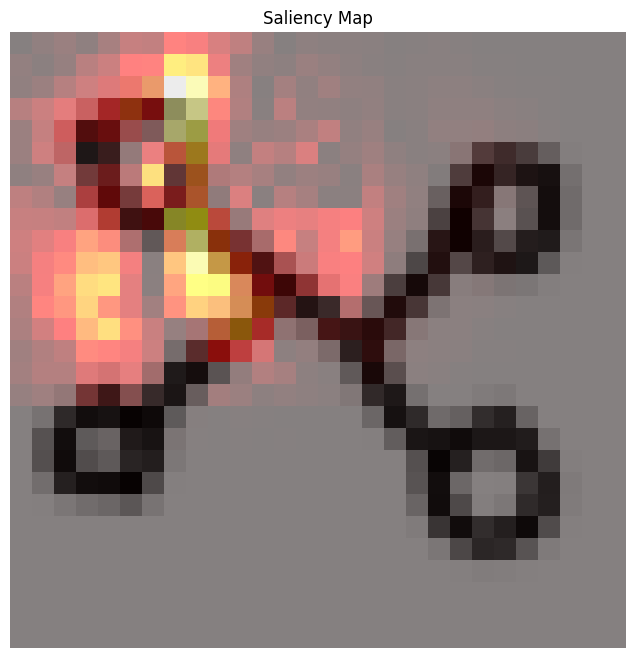

In [52]:
# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().detach().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


Using device: cpu
Episode 100/1000, Loss: 0.4584
Episode 200/1000, Loss: 0.0982
Episode 300/1000, Loss: 0.4216
Episode 400/1000, Loss: 0.2051
Episode 500/1000, Loss: 0.2990
Episode 600/1000, Loss: 0.0433
Episode 700/1000, Loss: 0.1824
Episode 800/1000, Loss: 0.0809
Episode 900/1000, Loss: 0.6285
Episode 1000/1000, Loss: 0.0449
Test Accuracy (Open-Set Recognition): 96.00%
Inference Result: Unknown


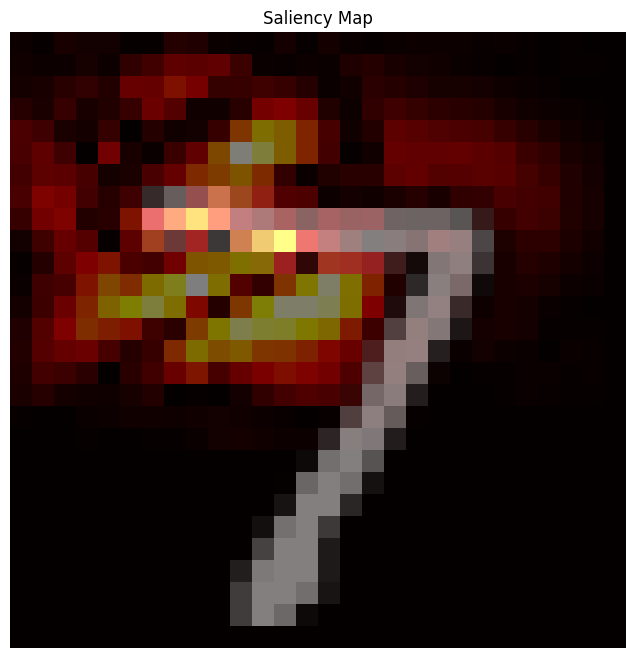

In [53]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 2. Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Prepare the MNIST Dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# 4. Extract Labels and Build Class-to-Indices Mapping
def extract_labels_and_build_mapping(dataset):
    labels = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels.append(label)
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    return labels, class_to_indices

# Extract labels and mappings for train and test datasets
train_labels, train_class_to_indices = extract_labels_and_build_mapping(train_dataset)
test_labels, test_class_to_indices = extract_labels_and_build_mapping(test_dataset)

# 5. Define the Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.primary_caps(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# 6. Define the Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings

# 7. Helper Functions
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances

def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances

# 8. Create Episode Function (Updated)
def create_episode(dataset, class_to_indices, n_way, k_shot, k_query):
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [
        cls for cls, idxs in class_to_indices.items() if len(idxs) >= k_shot + k_query
    ]
    
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot] if k_shot > 0 else []
        query_indices = selected_indices[k_shot:] if k_query > 0 else []

        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])

        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])

    # Only raise an error if k_query > 0 and no query images
    if k_query > 0 and len(query_images) == 0:
        raise ValueError("No query images available. Please adjust k_query or check the dataset.")

    # Only raise an error if k_shot > 0 and no support images
    if k_shot > 0 and len(support_images) == 0:
        raise ValueError("No support images available. Please adjust k_shot or check the dataset.")

    if len(support_images) > 0:
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
    else:
        support_images = None
        support_labels = None

    if len(query_images) > 0:
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
    else:
        query_images = None
        query_labels = None

    return support_images, support_labels, query_images, query_labels

# 9. Training Function
def train_prototypical_network(model, dataset, optimizer, class_to_indices,
                               num_episodes=1000, n_way=5, k_shot=5, k_query=5):
    model.train()
    for episode in range(num_episodes):
        try:
            support_images, support_labels, query_images, query_labels = create_episode(
                dataset, class_to_indices, n_way, k_shot, k_query)
        except ValueError as e:
            print(e)
            continue  # Skip this episode if not enough classes
        
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)

        optimizer.zero_grad()

        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)

        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]

        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)

        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")

# 10. Testing Function
def test_prototypical_network(model, train_dataset, train_class_to_indices, test_dataset, test_class_to_indices,
                              n_way=5, k_shot=0, k_query=5, threshold=1.0):
    model.eval()
    with torch.no_grad():
        # Create support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, train_class_to_indices, n_way, k_shot=5, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot=5)

        # Create query set from test dataset (unseen classes)
        try:
            _, _, query_images, query_labels = create_episode(
                test_dataset, test_class_to_indices, n_way, k_shot=0, k_query=k_query)
        except ValueError as e:
            print(e)
            return
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        query_embeddings = model(query_images)

        # Open-set recognition
        predicted_labels, min_distances = open_set_recognition(query_embeddings, prototypes, threshold)

        # Map unknown classes to -1
        true_labels = torch.full_like(query_labels, -1)
        accuracy = (predicted_labels == true_labels).float().mean().item()
        print(f"Test Accuracy (Open-Set Recognition): {accuracy * 100:.2f}%")

# 11. Initialize Model and Optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 12. Training Parameters
num_episodes = 1000
n_way = 5
k_shot = 5
k_query = 5

# 13. Train the Model
train_prototypical_network(model, train_dataset, optimizer, train_class_to_indices,
                           num_episodes, n_way, k_shot, k_query)

# 14. Test the Model
# Adjust testing parameters
n_way_test = 5       # Number of classes per episode
k_shot_test = 0      # Number of support samples per class in the test set
k_query_test = 5     # Number of query samples per class

threshold = 1.0  # Adjust based on validation
test_prototypical_network(model, train_dataset, train_class_to_indices,
                          test_dataset, test_class_to_indices, n_way=n_way_test,
                          k_shot=k_shot_test, k_query=k_query_test, threshold=threshold)

# 15. Compute Prototypes for Inference
with torch.no_grad():
    # Use the same n_way and k_shot as during training to compute prototypes
    support_images, support_labels, _, _ = create_episode(
        train_dataset, train_class_to_indices, n_way=n_way, k_shot=k_shot, k_query=0)
    support_images = support_images.to(device)
    support_labels = support_labels.to(device)
    support_embeddings = model(support_images)
    prototypes = compute_prototypes(support_embeddings, support_labels, n_way=n_way, k_shot=k_shot)

# 16. Inference with Explainability
class GuidedBackpropReLUModel(nn.Module):
    def __init__(self, model):
        super(GuidedBackpropReLUModel, self).__init__()
        self.model = model
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                if isinstance(module, nn.ReLU):
                    module_top._modules[idx] = GuidedReLU()
                elif len(module._modules) > 0:
                    recursive_relu_apply(module)

        recursive_relu_apply(self.model)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        input_image = input_image.to(device)
        input_image.requires_grad = True
        output = self.forward(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros_like(output)
        grad_target_map[0][target_class] = 1
        output.backward(grad_target_map)
        gradients_as_arr = input_image.grad.data.cpu().numpy()[0]
        return gradients_as_arr

class GuidedReLU(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

def inference_with_explainability(model, image, prototypes, threshold, explainer):
    model.eval()
    with torch.no_grad():
        embedding = model(image.to(device))
    predicted_labels, distances = open_set_recognition(embedding, prototypes, threshold)
    if predicted_labels.item() == -1:
        result = "Unknown"
        target_class = distances.argmin().item()
    else:
        result = f"Class {predicted_labels.item()}"
        target_class = predicted_labels.item()
    # Generate Saliency Map
    saliency_map = explainer.generate_gradients(image, target_class)
    saliency_map = np.transpose(saliency_map, (1, 2, 0))
    saliency_map = np.mean(np.abs(saliency_map), axis=2)
    return result, saliency_map

# Initialize the explainer
explainer = GuidedBackpropReLUModel(model.feature_extractor)

# Select a test image
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes,
                                                     threshold=threshold, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(test_image.squeeze().detach().cpu().numpy(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


Using device: cpu


100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [05:29<00:00, 517300.05it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Episode 100/1000, Loss: 1.4457
Episode 200/1000, Loss: 1.5218
Episode 300/1000, Loss: 1.3720
Episode 400/1000, Loss: 1.2105
Episode 500/1000, Loss: 1.4201
Episode 600/1000, Loss: 1.3894
Episode 700/1000, Loss: 1.3661
Episode 800/1000, Loss: 1.0593
Episode 900/1000, Loss: 1.4096
Episode 1000/1000, Loss: 1.1728


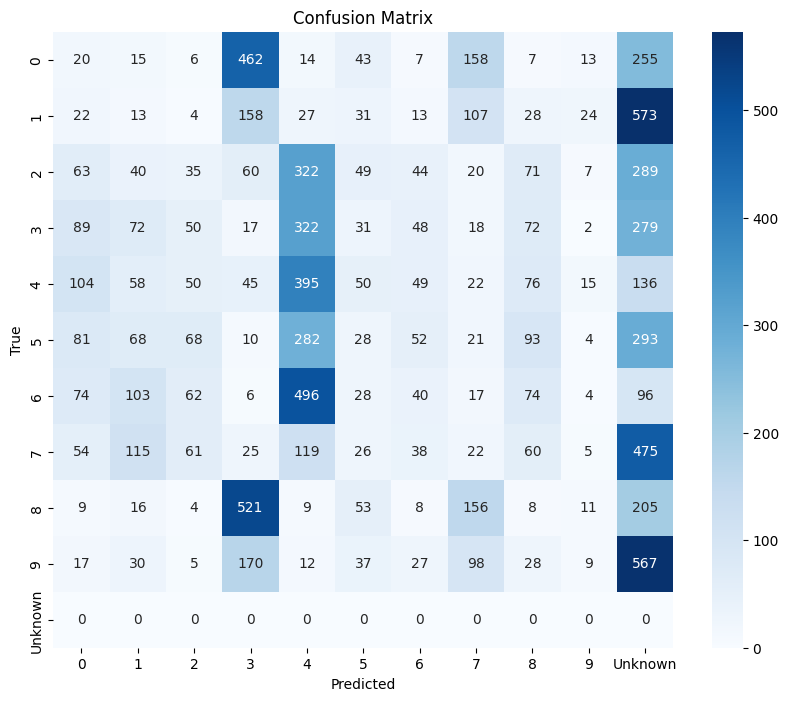

Test Accuracy: 5.87%
Inference Result: Class 5


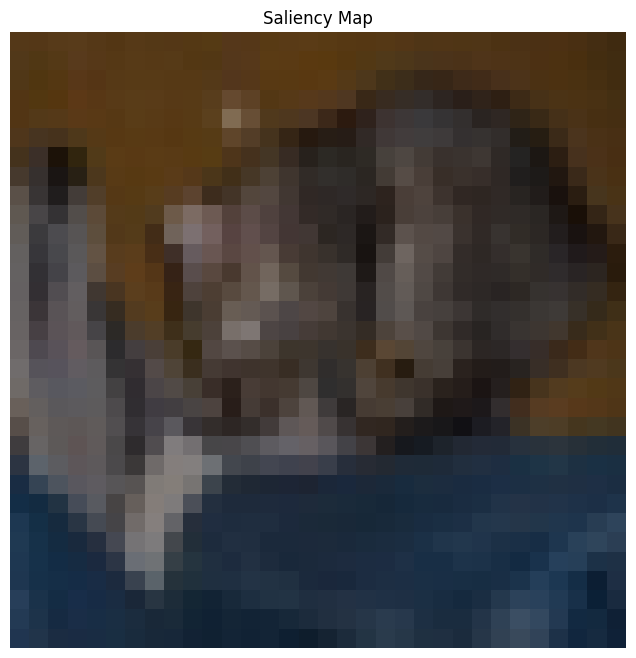

In [54]:
# 1. Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 2. Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 3. Prepare the CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset_full = datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# 4. Limit the Training Dataset to 100 Images per Class
def limit_dataset(dataset):
    class_to_indices = defaultdict(list)
    for idx, (image, label) in enumerate(dataset):
        class_to_indices[label].append(idx)

    limited_indices = []
    for cls in range(10):
        indices = class_to_indices[cls][:100]  # Limit to 100 images per class
        limited_indices.extend(indices)

    limited_dataset = torch.utils.data.Subset(dataset, limited_indices)
    return limited_dataset

train_dataset = limit_dataset(train_dataset_full)

# Rebuild class_to_indices mapping for the limited dataset
def extract_labels_and_build_mapping(dataset):
    labels = []
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        labels.append(label)
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    return labels, class_to_indices

train_labels, train_class_to_indices = extract_labels_and_build_mapping(train_dataset)
test_labels, test_class_to_indices = extract_labels_and_build_mapping(test_dataset)

# 5. Define the Capsule Network (Adjusted for CIFAR-10)
class CapsuleNet(nn.Module):
    def __init__(self, output_dim):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=5, stride=1)
        self.primary_caps = nn.Conv2d(256, 8 * 32, kernel_size=5, stride=2)
        self.output_dim = output_dim

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.primary_caps(x))
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 8)
        x = self.squash(x)
        x = x.view(batch_size, -1)
        return x[:, :self.output_dim]

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# 6. Define the Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, feature_extractor):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        embeddings = self.feature_extractor(x)
        return embeddings

# 7. Helper Functions
def compute_prototypes(embeddings, labels, n_way, k_shot):
    prototypes = []
    for i in range(n_way):
        class_embeddings = embeddings[labels == i]
        class_prototype = class_embeddings.mean(0)
        prototypes.append(class_prototype)
    prototypes = torch.stack(prototypes)
    return prototypes

def prototypical_loss(query_embeddings, query_labels, prototypes):
    distances = euclidean_distances(query_embeddings, prototypes)
    log_p_y = F.log_softmax(-distances, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).mean()
    return loss

def euclidean_distances(a, b):
    n = a.size(0)
    m = b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    distances = ((a - b) ** 2).sum(2)
    return distances

def open_set_recognition(embeddings, prototypes, threshold):
    distances = euclidean_distances(embeddings, prototypes)
    min_distances, predicted_labels = distances.min(1)
    is_known = min_distances <= threshold
    predicted_labels[~is_known] = -1  # Assign -1 to unknown classes
    return predicted_labels, min_distances

# 8. Create Episode Function
def create_episode(dataset, class_to_indices, n_way, k_shot, k_query):
    # Filter out classes that don't have enough samples
    classes_with_enough_samples = [
        cls for cls, idxs in class_to_indices.items() if len(idxs) >= k_shot + k_query
    ]
    if len(classes_with_enough_samples) < n_way:
        raise ValueError(f"Not enough classes with at least {k_shot + k_query} samples. "
                         f"Available: {len(classes_with_enough_samples)}, Required: {n_way}")
    selected_classes = random.sample(classes_with_enough_samples, n_way)
    support_images = []
    query_images = []
    support_labels = []
    query_labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    for cls in selected_classes:
        indices = class_to_indices[cls]
        selected_indices = random.sample(indices, k_shot + k_query)
        support_indices = selected_indices[:k_shot] if k_shot > 0 else []
        query_indices = selected_indices[k_shot:] if k_query > 0 else []
        for idx in support_indices:
            image, _ = dataset[idx]
            support_images.append(image)
            support_labels.append(class_to_idx[cls])
        for idx in query_indices:
            image, _ = dataset[idx]
            query_images.append(image)
            query_labels.append(class_to_idx[cls])
    # Only raise an error if k_query > 0 and no query images
    if k_query > 0 and len(query_images) == 0:
        raise ValueError("No query images available. Please adjust k_query or check the dataset.")
    # Only raise an error if k_shot > 0 and no support images
    if k_shot > 0 and len(support_images) == 0:
        raise ValueError("No support images available. Please adjust k_shot or check the dataset.")
    if len(support_images) > 0:
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
    else:
        support_images = None
        support_labels = None
    if len(query_images) > 0:
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
    else:
        query_images = None
        query_labels = None
    return support_images, support_labels, query_images, query_labels

# 9. Training Function
def train_prototypical_network(model, dataset, optimizer, class_to_indices,
                               num_episodes=1000, n_way=5, k_shot=5, k_query=5):
    model.train()
    for episode in range(num_episodes):
        try:
            support_images, support_labels, query_images, query_labels = create_episode(
                dataset, class_to_indices, n_way, k_shot, k_query)
        except ValueError as e:
            print(e)
            continue  # Skip this episode if not enough classes
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)
        query_labels = query_labels.to(device)
        optimizer.zero_grad()
        # Combine support and query images
        images = torch.cat([support_images, query_images], dim=0)
        embeddings = model(images)
        # Split embeddings
        support_embeddings = embeddings[:n_way * k_shot]
        query_embeddings = embeddings[n_way * k_shot:]
        # Compute prototypes
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot)
        # Compute loss
        loss = prototypical_loss(query_embeddings, query_labels, prototypes)
        loss.backward()
        optimizer.step()
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Loss: {loss.item():.4f}")

# 10. Testing Function (with Confusion Matrix)
def test_prototypical_network(model, train_dataset, train_class_to_indices, test_dataset, test_class_to_indices,
                              n_way=10, k_shot=0, k_query=5, threshold=1.0):
    model.eval()
    all_predicted_labels = []
    all_true_labels = []
    with torch.no_grad():
        # Create support set from training dataset
        support_images, support_labels, _, _ = create_episode(
            train_dataset, train_class_to_indices, n_way, k_shot=5, k_query=0)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        support_embeddings = model(support_images)
        prototypes = compute_prototypes(support_embeddings, support_labels, n_way, k_shot=5)
        # Iterate over test dataset
        for cls in range(10):
            indices = test_class_to_indices[cls]
            for idx in indices:
                image, label = test_dataset[idx]
                image = image.unsqueeze(0).to(device)
                embedding = model(image)
                predicted_label, _ = open_set_recognition(embedding, prototypes, threshold)
                predicted_label = predicted_label.item()
                all_predicted_labels.append(predicted_label)
                all_true_labels.append(cls)
    # Replace unknown class labels (-1) with 'Unknown' for confusion matrix
    all_predicted_labels = np.array(all_predicted_labels)
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels[all_predicted_labels == -1] = 10  # Assign 10 to 'Unknown'
    # Confusion Matrix
    class_names = [str(i) for i in range(10)] + ['Unknown']
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=list(range(11)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # Calculate accuracy excluding 'Unknown' class
    correct = (all_predicted_labels == all_true_labels)
    accuracy = np.mean(correct) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# 11. Initialize Model and Optimizer
feature_extractor = CapsuleNet(output_dim=64).to(device)
model = PrototypicalNetwork(feature_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 12. Training Parameters
num_episodes = 1000
n_way = 5
k_shot = 5
k_query = 5

# 13. Train the Model
train_prototypical_network(model, train_dataset, optimizer, train_class_to_indices,
                           num_episodes, n_way, k_shot, k_query)

# 14. Test the Model
# Adjust testing parameters
n_way_test = 10      # Number of classes per episode
k_shot_test = 0      # Number of support samples per class in the test set
k_query_test = 1     # Number of query samples per class

threshold = 1.0  # Adjust based on validation
test_prototypical_network(model, train_dataset, train_class_to_indices,
                          test_dataset, test_class_to_indices, n_way=n_way_test,
                          k_shot=k_shot_test, k_query=k_query_test, threshold=threshold)

# 15. Compute Prototypes for Inference
with torch.no_grad():
    # Use the same n_way and k_shot as during training to compute prototypes
    support_images, support_labels, _, _ = create_episode(
        train_dataset, train_class_to_indices, n_way=10, k_shot=5, k_query=0)
    support_images = support_images.to(device)
    support_labels = support_labels.to(device)
    support_embeddings = model(support_images)
    prototypes = compute_prototypes(support_embeddings, support_labels, n_way=10, k_shot=5)

# 16. Inference with Explainability
class GuidedBackpropReLUModel(nn.Module):
    def __init__(self, model):
        super(GuidedBackpropReLUModel, self).__init__()
        self.model = model
        self.model.eval()
        self.update_relus()

    def update_relus(self):
        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                if isinstance(module, nn.ReLU):
                    module_top._modules[idx] = GuidedReLU()
                elif len(module._modules) > 0:
                    recursive_relu_apply(module)

        recursive_relu_apply(self.model)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        input_image = input_image.to(device)
        input_image.requires_grad = True
        output = self.forward(input_image)
        self.model.zero_grad()
        grad_target_map = torch.zeros_like(output)
        grad_target_map[0][target_class] = 1
        output.backward(grad_target_map)
        gradients_as_arr = input_image.grad.data.cpu().numpy()[0]
        return gradients_as_arr

class GuidedReLU(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

def inference_with_explainability(model, image, prototypes, threshold, explainer):
    model.eval()
    with torch.no_grad():
        embedding = model(image.to(device))
    predicted_labels, distances = open_set_recognition(embedding, prototypes, threshold)
    if predicted_labels.item() == -1:
        result = "Unknown"
        target_class = distances.argmin().item()
    else:
        result = f"Class {predicted_labels.item()}"
        target_class = predicted_labels.item()
    # Generate Saliency Map
    saliency_map = explainer.generate_gradients(image, target_class)
    saliency_map = np.transpose(saliency_map, (1, 2, 0))
    saliency_map = np.mean(np.abs(saliency_map), axis=2)
    return result, saliency_map

# Initialize the explainer
explainer = GuidedBackpropReLUModel(model.feature_extractor)

# Select a test image
test_image, _ = test_dataset[0]
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Run inference
result, saliency_map = inference_with_explainability(model, test_image, prototypes,
                                                     threshold=threshold, explainer=explainer)
print("Inference Result:", result)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(test_image.squeeze().detach().cpu().numpy(), (1, 2, 0)))
plt.imshow(saliency_map, cmap='hot', alpha=0.5)
plt.title("Saliency Map")
plt.axis('off')
plt.show()


# New

In [55]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, known=True, transform=None, num_samples=10):
        self.transform = transform
        self.images = []
        self.labels = []
        self.known = known
        self.num_samples = num_samples
        self._create_dataset()
        
    def _create_dataset(self):
        for i in range(self.num_samples):
            if self.known:
                img = Image.new('RGB', (224, 224), color='white')
                draw = ImageDraw.Draw(img)
                draw.ellipse((60, 60, 160, 160), fill='gray', outline='black')
                self.images.append(img)
                self.labels.append(0)  # Class 'Cat'
            else:
                img = Image.new('RGB', (224, 224), color='white')
                draw = ImageDraw.Draw(img)
                draw.rectangle((80, 80, 140, 140), fill='orange', outline='black')
                self.images.append(img)
                self.labels.append(1)  # Class 'Unknown'

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] if self.known else -1  # -1 for unknown
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = CustomImageDataset(known=True, transform=transform, num_samples=10)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

unknown_dataset = CustomImageDataset(known=False, transform=transform, num_samples=5)
unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False)

# Capsule Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, in_channels, out_channels, num_routes):
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1).unsqueeze(4)
        priors = x @ self.route_weights
        logits = torch.zeros(*priors.size()).to(x.device)

        for i in range(3):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
            if i != 2:
                logits = logits + (priors * outputs).sum(dim=-1, keepdim=True)
        return outputs.squeeze(3).squeeze(1)

    @staticmethod
    def squash(s):
        s_norm = (s ** 2).sum(dim=-1, keepdim=True)
        scale = s_norm / (1 + s_norm)
        return scale * s / torch.sqrt(s_norm + 1e-8)

# Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.softmax    = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query  = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key    = self.key_conv(x).view(batch_size, -1, width * height)
        energy      = torch.bmm(proj_query, proj_key)
        attention   = self.softmax(energy)
        proj_value  = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = out + x
        return out

# Complete Model
class CapsuleAttentionModel(nn.Module):
    def __init__(self, num_classes, embedding_dim=256):
        super(CapsuleAttentionModel, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Base CNN
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=9, stride=2)
        self.relu = nn.ReLU(inplace=True)

        # Primary Capsules
        self.primary_capsules = nn.Conv2d(128, 8 * 32, kernel_size=9, stride=2)
        self.num_primary_capsules = 32
        self.primary_capsules_dim = 8

        # Digit Capsules
        self.digit_capsules = CapsuleLayer(num_capsules=num_classes,
                                           num_routes=self.num_primary_capsules * 6 * 6,
                                           in_channels=self.primary_capsules_dim,
                                           out_channels=16)

        # Attention Mechanism
        self.attention = SelfAttention(in_dim=16 * num_classes)

        # Embedding Layer
        self.fc = nn.Linear(16 * num_classes * 6 * 6, embedding_dim)

    def forward(self, x):
        # Base CNN
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Primary Capsules
        x = self.primary_capsules(x)
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_capsules, self.primary_capsules_dim, x.size(2), x.size(3))
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(batch_size, -1, self.primary_capsules_dim)

        # Digit Capsules
        x = self.digit_capsules(x)

        # Reshape for attention
        x = x.view(batch_size, -1, 6, 6)

        # Attention Mechanism
        x = self.attention(x)

        # Flatten and Embedding
        x = x.view(batch_size, -1)
        x = self.fc(x)
        x = F.normalize(x, dim=1)  # L2 Normalization

        return x

# Prototypical Loss
def prototypical_loss(input, target, prototypes):
    distances = torch.cdist(input, prototypes)
    target = target.long()
    loss = F.cross_entropy(-distances, target)
    return loss, distances

# Initialize Model and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1
embedding_dim = 256

model = CapsuleAttentionModel(num_classes=num_classes, embedding_dim=embedding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
prototypes = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        embeddings = model(images)

        # Compute prototypes
        prototypes = []
        for cls in range(num_classes):
            class_embeddings = embeddings[labels == cls]
            if len(class_embeddings) > 0:
                prototype = class_embeddings.mean(dim=0)
                prototypes.append(prototype)
            else:
                prototypes.append(torch.zeros(embedding_dim).to(device))
        prototypes = torch.stack(prototypes)

        loss, distances = prototypical_loss(embeddings, labels, prototypes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Compute Final Prototypes
model.eval()
with torch.no_grad():
    all_embeddings = []
    all_labels = []
    for images, labels in train_loader:
        images = images.to(device)
        embeddings = model(images)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    prototypes = []
    for cls in range(num_classes):
        class_embeddings = all_embeddings[all_labels == cls]
        prototype = class_embeddings.mean(dim=0)
        prototypes.append(prototype)
    prototypes = torch.stack(prototypes).to(device)

# Set Threshold T
with torch.no_grad():
    distances = torch.cdist(all_embeddings.to(device), prototypes)
    min_distances, _ = distances.min(dim=1)
    T = min_distances.max().item() + 0.1
    print(f"Threshold T for open-set recognition: {T:.4f}")

# Inference Function
def infer(model, image, prototypes, T):
    model.eval()
    with torch.no_grad():
        embedding = model(image.unsqueeze(0).to(device))
        distances = torch.cdist(embedding, prototypes)
        min_distance, predicted_class = distances.min(dim=1)
        if min_distance.item() <= T:
            label = 'Cat'
        else:
            label = 'Unknown'
        return label, min_distance.item(), distances.squeeze().cpu().numpy()

# Generate Visual Explanation
def generate_visual_explanation(model, image):
    model.eval()
    attention_map = None
    def hook_function(module, input, output):
        nonlocal attention_map
        attention_map = output
    handle = model.attention.register_forward_hook(hook_function)

    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))

    handle.remove()
    attention_map = attention_map.squeeze(0).cpu()
    attention_map = attention_map.mean(dim=0).numpy()
    attention_map -= attention_map.min()
    attention_map /= attention_map.max()
    attention_map = np.uint8(255 * attention_map)
    attention_map = Image.fromarray(attention_map).resize((224, 224), Image.BILINEAR)
    attention_map = np.array(attention_map)
    return attention_map

# Test on Known Images
model.eval()
correct = 0
total = 0

for images, labels in train_loader:
    images = images.to(device)
    for i in range(images.size(0)):
        image = images[i]
        label, distance, _ = infer(model, image, prototypes, T)
        if label == 'Cat':
            correct += 1
        total += 1

print(f"Accuracy on known classes: {100 * correct / total:.2f}%")

# Test on Unknown Images
unknown_correct = 0
unknown_total = 0

for images, _ in unknown_loader:
    images = images.to(device)
    for i in range(images.size(0)):
        image = images[i]
        label, distance, _ = infer(model, image, prototypes, T)
        if label == 'Unknown':
            unknown_correct += 1
        unknown_total += 1

print(f"Accuracy on unknown classes: {100 * unknown_correct / unknown_total:.2f}%")

# Visual Explanation Example
image, _ = unknown_dataset[0]
transformed_image = transform(image)
attention_map = generate_visual_explanation(model, transformed_image)

# Display the image and attention map
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Input Image")
ax[0].axis('off')

ax[1].imshow(image)
ax[1].imshow(attention_map, cmap='jet', alpha=0.5)
ax[1].set_title("Attention Map Overlay")
ax[1].axis('off')

plt.show()


RuntimeError: The size of tensor a (73728) must match the size of tensor b (1152) at non-singleton dimension 2

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

# Load CIFAR-10 dataset
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Prepare training data (only 'cat' class with 10 samples)
cat_class_index = 3  # 'cat' class index in CIFAR-10
cat_indices = [i for i, (_, label) in enumerate(cifar10_train) if label == cat_class_index]
train_indices = cat_indices[:10]
train_dataset = Subset(cifar10_train, train_indices)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Prepare test data with 'cat' images
test_cat_indices = [i for i, (_, label) in enumerate(cifar10_test) if label == cat_class_index]
test_cat_indices = test_cat_indices[:50]
test_dataset = Subset(cifar10_test, test_cat_indices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare unknown data (classes other than 'cat')
unknown_indices = [i for i, (_, label) in enumerate(cifar10_test) if label != cat_class_index]
unknown_indices = unknown_indices[:50]
unknown_dataset = Subset(cifar10_test, unknown_indices)
unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False)

# Define Capsule Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, in_channels, out_channels, num_routes):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_routes = num_routes

        self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_routes, self.in_channels)
        x = x.unsqueeze(1).unsqueeze(4)
        priors = torch.matmul(x, self.route_weights)
        logits = torch.zeros_like(priors).to(x.device)

        num_iterations = 3
        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
            if i != num_iterations - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits
        outputs = outputs.squeeze(3).squeeze(1)
        return outputs

    @staticmethod
    def squash(s):
        s_norm = torch.sum(s ** 2, dim=-1, keepdim=True)
        scale = s_norm / (1 + s_norm)
        return scale * s / torch.sqrt(s_norm + 1e-8)

# Define Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.in_dim = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query.permute(0, 2, 1), proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = out + x
        return out

# Define the Capsule Attention Model
class CapsuleAttentionModel(nn.Module):
    def __init__(self, num_classes=1, embedding_dim=256):
        super(CapsuleAttentionModel, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Base CNN
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2)
        self.relu = nn.ReLU(inplace=True)

        # Primary Capsules
        self.primary_capsules = nn.Conv2d(128, 8 * 32, kernel_size=5, stride=2)
        self.num_primary_capsules = 32
        self.primary_capsules_dim = 8

        # Digit Capsules
        self.digit_capsules = CapsuleLayer(num_capsules=num_classes,
                                           num_routes=self.num_primary_capsules * 2 * 2,
                                           in_channels=self.primary_capsules_dim,
                                           out_channels=16)

        # Attention Mechanism
        self.attention = SelfAttention(in_dim=16 * num_classes)

        # Embedding Layer
        self.fc = nn.Linear(16 * num_classes * 2 * 2, embedding_dim)

    def forward(self, x):
        # Base CNN
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Primary Capsules
        x = self.primary_capsules(x)
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_capsules, self.primary_capsules_dim, x.size(2), x.size(3))
        x = x.permute(0, 1, 3, 4, 2).contiguous()
        x = x.view(batch_size, -1, self.primary_capsules_dim)

        # Digit Capsules
        x = self.digit_capsules(x)

        # Reshape for attention
        x = x.view(batch_size, -1, 2, 2)

        # Attention Mechanism
        x = self.attention(x)

        # Flatten and Embedding
        x = x.view(batch_size, -1)
        x = self.fc(x)
        x = F.normalize(x, dim=1)  # L2 Normalization

        return x

# Define Prototypical Loss
def prototypical_loss(inputs, targets, prototypes):
    distances = torch.cdist(inputs, prototypes)
    targets = targets.long()
    loss = F.cross_entropy(-distances, targets)
    return loss, distances

# Initialize the model and optimizer
model = CapsuleAttentionModel(num_classes=1, embedding_dim=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = torch.zeros_like(labels)  # All labels are 0 for 'cat'
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(images)

        # Compute prototype
        prototype = embeddings.mean(dim=0, keepdim=True)
        prototypes = prototype  # Only one class

        loss, distances = prototypical_loss(embeddings, labels, prototypes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Compute final prototype
model.eval()
with torch.no_grad():
    all_embeddings = []
    all_labels = []
    for images, labels in train_loader:
        images = images.to(device)
        embeddings = model(images)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    # Since there's only one class, compute prototype
    prototype = all_embeddings.mean(dim=0, keepdim=True)
    prototypes = prototype.to(device)

# Set threshold T
with torch.no_grad():
    distances = torch.cdist(all_embeddings.to(device), prototypes)
    min_distances = distances.squeeze()
    T = min_distances.max().item() + 0.1  # Adding a margin
    print(f"Threshold T for open-set recognition: {T:.4f}")

# Define inference function
def infer(model, image, prototypes, T):
    model.eval()
    with torch.no_grad():
        embedding = model(image.unsqueeze(0).to(device))
        distances = torch.cdist(embedding, prototypes)
        min_distance = distances.item()
        if min_distance <= T:
            label = 'Cat'
        else:
            label = 'Unknown'
        return label, min_distance

# Generate visual explanation
def generate_visual_explanation(model, image):
    model.eval()
    attention_map = None

    def hook_function(module, input, output):
        nonlocal attention_map
        attention_map = output

    handle = model.attention.register_forward_hook(hook_function)

    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))

    handle.remove()
    attention_map = attention_map.squeeze(0).cpu()
    attention_map = attention_map.mean(dim=0).numpy()
    attention_map -= attention_map.min()
    attention_map /= attention_map.max()
    attention_map = np.uint8(255 * attention_map)
    attention_map = Image.fromarray(attention_map).resize((32, 32), Image.BILINEAR)
    attention_map = np.array(attention_map)
    return attention_map

# Test on known images
correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    label, min_distance = infer(model, images[0], prototypes, T)
    if label == 'Cat':
        correct += 1
    total += 1

print(f"Accuracy on known classes: {100 * correct / total:.2f}%")

# Test on unknown images
unknown_correct = 0
unknown_total = 0

for images, labels in unknown_loader:
    images = images.to(device)
    label, min_distance = infer(model, images[0], prototypes, T)
    if label == 'Unknown':
        unknown_correct += 1
    unknown_total += 1

print(f"Accuracy on unknown classes: {100 * unknown_correct / unknown_total:.2f}%")

# Visual explanation example
import matplotlib.pyplot as plt

# Select an image from unknown dataset
unknown_iter = iter(unknown_loader)
images, _ = next(unknown_iter)
image = images[0]
attention_map = generate_visual_explanation(model, image)

# Inverse normalization for visualization
inv_transform = transforms.Normalize(
    mean=[-0.4914 / 0.2023, -0.4822 / 0.1994, -0.4465 / 0.2010],
    std=[1 / 0.2023, 1 / 0.1994, 1 / 0.2010]
)

image = inv_transform(image)
image = image.permute(1, 2, 0).cpu().numpy()
image = np.clip(image, 0, 1)

# Display the image and attention map
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Input Image")
ax[0].axis('off')

ax[1].imshow(image)
ax[1].imshow(attention_map, cmap='jet', alpha=0.5)
ax[1].set_title("Attention Map Overlay")
ax[1].axis('off')

plt.show()


Files already downloaded and verified
Files already downloaded and verified


RuntimeError: shape '[2, 128, 8]' is invalid for input of size 8192

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST dimensions
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],
                         std=[0.3081])
])

# Load CIFAR-10 dataset and extract 'cat' class
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Filter out the 'cat' class (class index 3 in CIFAR-10)
cat_class_index = 3

# Prepare training data (only 'cat' class with 10 samples)
cat_indices = [i for i, (_, label) in enumerate(cifar10_train) if label == cat_class_index]
train_indices = cat_indices[:10]
train_dataset = Subset(cifar10_train, train_indices)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Prepare test data with 'cat' images
test_cat_indices = [i for i, (_, label) in enumerate(cifar10_test) if label == cat_class_index]
test_cat_indices = test_cat_indices[:50]
test_dataset = Subset(cifar10_test, test_cat_indices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare unknown data (classes other than 'cat')
unknown_indices = [i for i, (_, label) in enumerate(cifar10_test) if label != cat_class_index]
unknown_indices = unknown_indices[:50]
unknown_dataset = Subset(cifar10_test, unknown_indices)
unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False)

# Define Capsule Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules

        self.route_weights = nn.Parameter(
            torch.randn(num_capsules, num_route_nodes, in_channels, out_channels)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(2)  # Add extra dim for num_capsules
        priors = torch.matmul(x.unsqueeze(3), self.route_weights)  # Matrix multiplication

        logits = torch.zeros(*priors.size()).to(x.device)
        num_iterations = 3
        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
            if i != num_iterations - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits
        outputs = outputs.squeeze(2).squeeze(3)
        return outputs

    @staticmethod
    def squash(s):
        s_norm = (s ** 2).sum(dim=-1, keepdim=True)
        scale = s_norm / (1 + s_norm)
        return scale * s / torch.sqrt(s_norm + 1e-8)

# Define the Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, num_classes=1):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.relu = nn.ReLU(inplace=True)

        self.primary_capsules = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.num_primary_capsules = 32
        self.primary_capsules_dim = 8

        self.digit_capsules = CapsuleLayer(
            num_capsules=num_classes,
            num_route_nodes=32 * 6 * 6,
            in_channels=8,
            out_channels=16
        )

        self.decoder = nn.Sequential(
            nn.Linear(16 * num_classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))

        x = self.primary_capsules(x)
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_capsules, self.primary_capsules_dim, -1).permute(0, 1, 3, 2)
        x = x.contiguous().view(batch_size, self.num_primary_capsules * x.size(2), self.primary_capsules_dim)

        print(f"Shape before digit_capsules: {x.shape}")  # Debugging shape
        x = self.digit_capsules(x)

        x = x.squeeze()
        x_norm = x.norm(dim=1)
        return x, x_norm

# Initialize the model and optimizer
model = CapsuleNet(num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_embeddings = []
    all_labels = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = torch.zeros(images.size(0)).long().to(device)  # All labels are 0 for 'cat'

        optimizer.zero_grad()
        embeddings, _ = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)
        all_embeddings.append(embeddings.detach().cpu())
        all_labels.append(labels.cpu())

        # Compute prototype
        prototype = embeddings.mean(dim=0, keepdim=True)
        prototypes = prototype  # Only one class

        # Compute distances
        distances = torch.cdist(embeddings, prototypes)

        # Compute loss
        loss = F.mse_loss(distances.squeeze(), torch.zeros_like(distances).squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Compute final prototype
model.eval()
with torch.no_grad():
    all_embeddings = []
    all_labels = []
    for images, labels in train_loader:
        images = images.to(device)
        embeddings, _ = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    # Since there's only one class, compute prototype
    prototype = all_embeddings.mean(dim=0, keepdim=True)
    prototypes = prototype.to(device)

# Set threshold T
with torch.no_grad():
    distances = torch.cdist(all_embeddings.to(device), prototypes)
    min_distances = distances.squeeze()
    T = min_distances.max().item() + 0.1  # Adding a margin
    print(f"Threshold T for open-set recognition: {T:.4f}")

# Define inference function
def infer(model, image, prototypes, T):
    model.eval()
    with torch.no_grad():
        embeddings, _ = model(image.unsqueeze(0).to(device))
        embeddings = embeddings.view(embeddings.size(0), -1)
        distances = torch.cdist(embeddings, prototypes)
        min_distance = distances.item()
        if min_distance <= T:
            label = 'Cat'
        else:
            label = 'Unknown'
        return label, min_distance

# Test on known images
correct = 0
total = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    label, min_distance = infer(model, images[0], prototypes, T)
    if label == 'Cat':
        correct += 1
    total += 1

print(f"Accuracy on known classes: {100 * correct / total:.2f}%")

# Test on unknown images
unknown_correct = 0
unknown_total = 0

for images, labels in unknown_loader:
    images = images.to(device)
    label, min_distance = infer(model, images[0], prototypes, T)
    if label == 'Unknown':
        unknown_correct += 1
    unknown_total += 1

print(f"Accuracy on unknown classes: {100 * unknown_correct / unknown_total:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Epoch [1/50], Loss: 63.8804
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Epoch [2/50], Loss: 36.4060
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Shape before digit_capsules: torch.Size([2, 1152, 8])
Epoch [3/50], Loss: 37.6671
Shape before digit_capsules: t

RuntimeError: X1 and X2 must have the same number of columns. X1: 16 X2: 18432

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match MNIST dimensions
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

# Load CIFAR-10 dataset
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Filter 'cat' class (index 3 in CIFAR-10)
cat_class_index = 3

# Prepare training data
cat_indices = [i for i, (_, label) in enumerate(cifar10_train) if label == cat_class_index]
train_indices = cat_indices[:10]
train_dataset = Subset(cifar10_train, train_indices)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Prepare test data
test_cat_indices = [i for i, (_, label) in enumerate(cifar10_test) if label == cat_class_index]
test_cat_indices = test_cat_indices[:50]
test_dataset = Subset(cifar10_test, test_cat_indices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare unknown data
unknown_indices = [i for i, (_, label) in enumerate(cifar10_test) if label != cat_class_index]
unknown_indices = unknown_indices[:50]
unknown_dataset = Subset(cifar10_test, unknown_indices)
unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False)

# Define Capsule Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.route_weights = nn.Parameter(
            torch.randn(num_capsules, num_route_nodes, in_channels, out_channels)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(2)  # Add extra dim for num_capsules
        priors = torch.matmul(x.unsqueeze(3), self.route_weights)

        logits = torch.zeros(*priors.size()).to(x.device)
        num_iterations = 3
        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
            if i != num_iterations - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits
        outputs = outputs.squeeze(2).squeeze(3)
        return outputs

    @staticmethod
    def squash(s):
        s_norm = (s ** 2).sum(dim=-1, keepdim=True)
        scale = s_norm / (1 + s_norm)
        return scale * s / torch.sqrt(s_norm + 1e-8)

# Define Capsule Network
class CapsuleNet(nn.Module):
    def __init__(self, num_classes=1):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.relu = nn.ReLU(inplace=True)

        self.primary_capsules = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.num_primary_capsules = 32
        self.primary_capsules_dim = 8

        self.digit_capsules = CapsuleLayer(
            num_capsules=num_classes,
            num_route_nodes=32 * 6 * 6,
            in_channels=8,
            out_channels=16
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.primary_capsules(x)
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_capsules, self.primary_capsules_dim, -1).permute(0, 1, 3, 2)
        x = x.contiguous().view(batch_size, self.num_primary_capsules * x.size(2), self.primary_capsules_dim)
        return self.digit_capsules(x)

# Initialize model and optimizer
model = CapsuleNet(num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_embeddings = []
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)
        all_embeddings.append(embeddings.detach().cpu())

        prototype = embeddings.mean(dim=0, keepdim=True)
        distances = torch.cdist(embeddings, prototype)
        loss = F.mse_loss(distances.squeeze(), torch.zeros_like(distances).squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Calculate prototype and threshold
model.eval()
with torch.no_grad():
    all_embeddings = []
    for images, _ in train_loader:
        images = images.to(device)
        embeddings = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)
        all_embeddings.append(embeddings.cpu())
    all_embeddings = torch.cat(all_embeddings)
    prototype = all_embeddings.mean(dim=0, keepdim=True).to(device)

    distances = torch.cdist(all_embeddings.to(device), prototype)
    T = distances.max().item() + 0.1
    print(f"Threshold T for open-set recognition: {T:.4f}")

# Define inference function
def infer(model, image, prototypes, T):
    model.eval()
    with torch.no_grad():
        embeddings = model(image.unsqueeze(0).to(device))
        embeddings = embeddings.view(embeddings.size(0), -1)
        prototypes = prototypes.unsqueeze(0)
        distances = torch.cdist(embeddings, prototypes)
        min_distance = distances.item()
        label = 'Cat' if min_distance <= T else 'Unknown'
        return label, min_distance

# Test on known and unknown data
correct_known, total_known = 0, 0
for images, _ in test_loader:
    label, _ = infer(model, images[0], prototype, T)
    if label == 'Cat':
        correct_known += 1
    total_known += 1

correct_unknown, total_unknown = 0, 0
for images, _ in unknown_loader:
    label, _ = infer(model, images[0], prototype, T)
    if label == 'Unknown':
        correct_unknown += 1
    total_unknown += 1

print(f"Accuracy on known classes: {100 * correct_known / total_known:.2f}%")
print(f"Accuracy on unknown classes: {100 * correct_unknown / total_unknown:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Loss: 43.5363
Epoch [2/50], Loss: 46.1068
Epoch [3/50], Loss: 28.6192
Epoch [4/50], Loss: 25.1506
Epoch [5/50], Loss: 23.8908
Epoch [6/50], Loss: 24.0974
Epoch [7/50], Loss: 18.0789
Epoch [8/50], Loss: 11.7558
Epoch [9/50], Loss: 12.9341
Epoch [10/50], Loss: 9.8420
Epoch [11/50], Loss: 5.8394
Epoch [12/50], Loss: 4.7906
Epoch [13/50], Loss: 2.2661
Epoch [14/50], Loss: 1.9839
Epoch [15/50], Loss: 2.0767
Epoch [16/50], Loss: 2.0052
Epoch [17/50], Loss: 1.5122
Epoch [18/50], Loss: 1.4479
Epoch [19/50], Loss: 1.3011
Epoch [20/50], Loss: 1.2610
Epoch [21/50], Loss: 1.2080
Epoch [22/50], Loss: 1.0417
Epoch [23/50], Loss: 1.2392
Epoch [24/50], Loss: 1.6456
Epoch [25/50], Loss: 1.9891
Epoch [26/50], Loss: 2.1656
Epoch [27/50], Loss: 3.2251
Epoch [28/50], Loss: 3.7086
Epoch [29/50], Loss: 1.7464
Epoch [30/50], Loss: 1.6665
Epoch [31/50], Loss: 1.5996
Epoch [32/50], Loss: 1.5153
Epoch [33/50], Loss: 1.0982


# Cifar-10, 500 image per class

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

# Load CIFAR-10 dataset
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Prepare training and testing datasets
train_indices = []
test_indices = []

for class_idx in range(10):  # Loop over all 10 classes
    # Get indices for the current class
    class_indices = [i for i, (_, label) in enumerate(cifar10_train) if label == class_idx]
    train_indices += class_indices[:500]  # First 50 images for training

    test_class_indices = [i for i, (_, label) in enumerate(cifar10_test) if label == class_idx]
    test_indices += test_class_indices  # All test images for testing



Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Subset datasets for training and testing
train_dataset = Subset(cifar10_train, train_indices)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = Subset(cifar10_test, test_indices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [64]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.route_weights = nn.Parameter(
            torch.randn(num_capsules, num_route_nodes, in_channels, out_channels)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(2)  # Add extra dim for num_capsules
        priors = torch.einsum('bijf,jkfo->biko', x, self.route_weights)

        logits = torch.zeros(*priors.size()).to(x.device)
        num_iterations = 3
        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
            if i != num_iterations - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits

        #print(f"Shape before squeeze: {outputs.shape}")
        outputs = outputs.squeeze(2)  # Remove the third dimension
        if outputs.dim() == 4:
            outputs = outputs.squeeze(3)  # Remove the fourth dimension if it exists
        #print(f"Shape after squeeze: {outputs.shape}")
        return outputs

    @staticmethod
    def squash(s):
        s_norm = (s ** 2).sum(dim=-1, keepdim=True)
        scale = s_norm / (1 + s_norm)
        return scale * s / torch.sqrt(s_norm + 1e-8)


class CapsuleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.relu = nn.ReLU(inplace=True)

        self.primary_capsules = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.num_primary_capsules = 32
        self.primary_capsules_dim = 8
        self.primary_capsules_height = 6  # Based on CIFAR-10 dimensions (28x28)
        self.primary_capsules_width = 6

        self.digit_capsules = CapsuleLayer(
            num_capsules=num_classes,
            num_route_nodes=self.num_primary_capsules * self.primary_capsules_height * self.primary_capsules_width,
            in_channels=self.primary_capsules_dim,
            out_channels=16
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.primary_capsules(x)
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_capsules, self.primary_capsules_dim, -1).permute(0, 1, 3, 2)
        x = x.contiguous().view(batch_size, self.num_primary_capsules * x.size(2), self.primary_capsules_dim)
        return self.digit_capsules(x)


# Initialize model and optimizer
model = CapsuleNet(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
class_prototypes = {}
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    class_embeddings = {i: [] for i in range(10)}  # Store embeddings per class
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)

        # Collect embeddings per class
        for i, label in enumerate(labels):
            class_embeddings[label.item()].append(embeddings[i].detach().cpu())

        prototype = embeddings.mean(dim=0, keepdim=True)
        distances = torch.cdist(embeddings, prototype)
        loss = F.mse_loss(distances.squeeze(), torch.zeros_like(distances).squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Compute prototypes for each class
    with torch.no_grad():
        for class_idx, embeddings_list in class_embeddings.items():
            class_prototypes[class_idx] = torch.stack(embeddings_list).mean(dim=0).to(device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


# Testing loop with multi-class inference
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        embeddings = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)

        # Calculate distances to each prototype
        distances_list = []
        for prototype in class_prototypes.values():
            # Ensure prototypes and embeddings are compatible
            distance = torch.cdist(embeddings, prototype.unsqueeze(0))  # Compute distances
            distances_list.append(distance.squeeze(1))  # Squeeze only the relevant dimension

        # Stack distances across prototypes
        distances = torch.stack(distances_list, dim=1)
        #print(f"Distances shape: {distances.shape}")  # Debugging shape

        # Determine the class with the minimum distance
        predicted_labels = distances.argmin(dim=1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

# Print test accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")



KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Ensure all prototypes are available
prototype_tensor = torch.stack(list(class_prototypes.values())).to(device)  # [num_classes, feature_dim]

# Compute pairwise distances between prototypes
pairwise_distances = torch.cdist(prototype_tensor, prototype_tensor)  # [num_classes, num_classes]

# Convert to CPU for visualization
pairwise_distances = pairwise_distances.cpu().detach().numpy()

# Visualize the pairwise distance matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pairwise_distances, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.title("Pairwise Distances Between Class Prototypes")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

# Print distances for debugging
print("Pairwise Prototype Distances:")
print(pairwise_distances)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = torch.cat([model(images.to(device)).view(images.size(0), -1) for images, _ in test_loader])
labels = torch.cat([labels for _, labels in test_loader])

tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings.cpu().numpy())

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="tab10")
plt.colorbar()
plt.title("t-SNE Visualization of Embeddings")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

# Load CIFAR-10 dataset
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Prepare training and testing datasets
train_indices = []
test_indices = []

for class_idx in range(10):  # Loop over all 10 classes
    # Get indices for the current class
    class_indices = [i for i, (_, label) in enumerate(cifar10_train) if label == class_idx]
    train_indices += class_indices[:200]  # First 50 images for training

    test_class_indices = [i for i, (_, label) in enumerate(cifar10_test) if label == class_idx]
    test_indices += test_class_indices  # All test images for testing



# Subset datasets for training and testing
train_dataset = Subset(cifar10_train, train_indices)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = Subset(cifar10_test, test_indices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.route_weights = nn.Parameter(
            torch.randn(num_capsules, num_route_nodes, in_channels, out_channels)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(2)  # Add extra dim for num_capsules
        priors = torch.einsum('bijf,jkfo->biko', x, self.route_weights)

        logits = torch.zeros(*priors.size()).to(x.device)
        num_iterations = 3
        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))
            if i != num_iterations - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits

        #print(f"Shape before squeeze: {outputs.shape}")
        outputs = outputs.squeeze(2)  # Remove the third dimension
        if outputs.dim() == 4:
            outputs = outputs.squeeze(3)  # Remove the fourth dimension if it exists
        #print(f"Shape after squeeze: {outputs.shape}")
        return outputs

    @staticmethod
    def squash(s):
        s_norm = (s ** 2).sum(dim=-1, keepdim=True)
        scale = s_norm / (1 + s_norm)
        return scale * s / torch.sqrt(s_norm + 1e-8)


class CapsuleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.relu = nn.ReLU(inplace=True)

        self.primary_capsules = nn.Conv2d(256, 8 * 32, kernel_size=9, stride=2)
        self.num_primary_capsules = 32
        self.primary_capsules_dim = 8
        self.primary_capsules_height = 6  # Based on CIFAR-10 dimensions (28x28)
        self.primary_capsules_width = 6

        self.digit_capsules = CapsuleLayer(
            num_capsules=num_classes,
            num_route_nodes=self.num_primary_capsules * self.primary_capsules_height * self.primary_capsules_width,
            in_channels=self.primary_capsules_dim,
            out_channels=16
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.primary_capsules(x)
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_primary_capsules, self.primary_capsules_dim, -1).permute(0, 1, 3, 2)
        x = x.contiguous().view(batch_size, self.num_primary_capsules * x.size(2), self.primary_capsules_dim)
        return self.digit_capsules(x)


# Initialize model and optimizer
model = CapsuleNet(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
class_prototypes = {}
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    class_embeddings = {i: [] for i in range(10)}  # Store embeddings per class
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)

        # Collect embeddings per class
        for i, label in enumerate(labels):
            class_embeddings[label.item()].append(embeddings[i].detach().cpu())

        prototype = embeddings.mean(dim=0, keepdim=True)
        distances = torch.cdist(embeddings, prototype)
        loss = F.mse_loss(distances.squeeze(), torch.zeros_like(distances).squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Compute prototypes for each class
    with torch.no_grad():
        for class_idx, embeddings_list in class_embeddings.items():
            class_prototypes[class_idx] = torch.stack(embeddings_list).mean(dim=0).to(device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


# Testing loop with multi-class inference
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        embeddings = model(images)
        embeddings = embeddings.view(embeddings.size(0), -1)

        # Calculate distances to each prototype
        distances_list = []
        for prototype in class_prototypes.values():
            # Ensure prototypes and embeddings are compatible
            distance = torch.cdist(embeddings, prototype.unsqueeze(0))  # Compute distances
            distances_list.append(distance.squeeze(1))  # Squeeze only the relevant dimension

        # Stack distances across prototypes
        distances = torch.stack(distances_list, dim=1)
        #print(f"Distances shape: {distances.shape}")  # Debugging shape

        # Determine the class with the minimum distance
        predicted_labels = distances.argmin(dim=1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)

# Print test accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")



import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Ensure all prototypes are available
prototype_tensor = torch.stack(list(class_prototypes.values())).to(device)  # [num_classes, feature_dim]

# Compute pairwise distances between prototypes
pairwise_distances = torch.cdist(prototype_tensor, prototype_tensor)  # [num_classes, num_classes]

# Convert to CPU for visualization
pairwise_distances = pairwise_distances.cpu().detach().numpy()

# Visualize the pairwise distance matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pairwise_distances, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.title("Pairwise Distances Between Class Prototypes")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

# Print distances for debugging
print("Pairwise Prototype Distances:")
print(pairwise_distances)



